In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Set the style using seaborn
sns.set(style='whitegrid')

# Set the figure size
plt.figure(figsize=(20, 6))

# Set the path to your dataset directories
closed_dir = r"/Users/yuktasharma/Downloads/train/Closed"
open_dir = r"/Users/yuktasharma/Downloads/train/Open"
yawn_dir = r"/Users/yuktasharma/Downloads/train/yawn"
no_yawn_dir = r"/Users/yuktasharma/Downloads/train/no_yawn"

<Figure size 2000x600 with 0 Axes>

In [3]:
# Function to load the dataset
def load_dataset():
    dataset = []
    
    # Load drowsy samples
    for filename in os.listdir(closed_dir):
        image = cv2.imread(os.path.join(closed_dir, filename))
        dataset.append((image, 'Closed'))  # Assign label 'Drowsy' for drowsy samples
    
    # Load non-drowsy samples
    for filename in os.listdir(open_dir):
        image = cv2.imread(os.path.join(open_dir, filename))
        dataset.append((image, 'Open'))  # Assign label 'Not Drowsy' for non-drowsy samples

    for filename in os.listdir(yawn_dir):
        image = cv2.imread(os.path.join(yawn_dir, filename))
        dataset.append((image, 'yawn'))  # Assign label 'Drowsy' for drowsy samples

    for filename in os.listdir(no_yawn_dir):
        image = cv2.imread(os.path.join(no_yawn_dir, filename))
        dataset.append((image, 'no_yawn'))  # Assign label 'Drowsy' for drowsy samples
    return dataset

In [4]:
# Preprocessing function
def preprocess_image(image):
    image = cv2.resize(image, (64, 64))
    image = image / 255.0
    return image

In [5]:
# Load and preprocess the dataset
dataset = load_dataset()

preprocessed_images = []
labels = []

for image, label in dataset:
    preprocessed_image = preprocess_image(image)
    preprocessed_images.append(preprocessed_image)
    labels.append(label)

In [6]:
# Convert the lists to NumPy arrays
preprocessed_images = np.array(preprocessed_images)
labels = np.array(labels)

In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=42)

In [8]:
# Convert labels to numerical values
label_to_id = {'Closed': 0, 'Open': 1, 'yawn': 2, 'no_yawn': 3}
# No need for one-hot encoding, revert back to integer labels
y_train_ids = np.array([label_to_id[label] for label in y_train])
y_test_ids = np.array([label_to_id[label] for label in y_test])

In [9]:
from keras.utils import to_categorical

# Assuming y_train_ids and y_test_ids are your integer labels
num_classes = 4  # Number of categories in your data
y_train_one_hot = to_categorical(y_train_ids, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_ids, num_classes=num_classes)


In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class classification
              metrics=['accuracy'])

In [11]:
# Train the model
model.fit(X_train, y_train_one_hot, epochs=15, batch_size=32)

Epoch 1/15
73/73 [==============================] - 5s 67ms/step - loss: 0.6982 - accuracy: 0.6629
Epoch 2/15
73/73 [==============================] - 5s 62ms/step - loss: 0.4278 - accuracy: 0.7858
Epoch 3/15
73/73 [==============================] - 5s 70ms/step - loss: 0.3592 - accuracy: 0.8164
Epoch 4/15
73/73 [==============================] - 6s 78ms/step - loss: 0.3344 - accuracy: 0.8263
Epoch 5/15
73/73 [==============================] - 5s 64ms/step - loss: 0.3220 - accuracy: 0.8267
Epoch 6/15
73/73 [==============================] - 5s 64ms/step - loss: 0.3031 - accuracy: 0.8448
Epoch 7/15
73/73 [==============================] - 5s 64ms/step - loss: 0.2939 - accuracy: 0.8427
Epoch 8/15
73/73 [==============================] - 5s 64ms/step - loss: 0.2827 - accuracy: 0.8685
Epoch 9/15
73/73 [==============================] - 5s 66ms/step - loss: 0.2644 - accuracy: 0.8672
Epoch 10/15
73/73 [==============================] - 5s 68ms/step - loss: 0.2281 - accuracy: 0.8961
Epoch 11/

In [12]:
# Extract features from the trained CNN model
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

19/19 [==============================] - 0s 17ms/step


In [13]:
# Train an SVM classifier using the extracted features
svm_classifier = svm.SVC()
# Convert one-hot encoded labels to categorical labels
y_train_categorical = np.argmax(y_train_one_hot, axis=1)
# Train the SVM classifier
svm_classifier.fit(train_features, y_train_categorical)

SVC()

In [14]:
# Predict labels for training and testing sets
train_predictions = svm_classifier.predict(train_features)
test_predictions = svm_classifier.predict(test_features)

In [15]:
# Calculate accuracy
train_accuracy = accuracy_score(y_train_ids, train_predictions)
test_accuracy = accuracy_score(y_test_ids, test_predictions)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.993103448275862
Testing Accuracy: 0.9637931034482758


In [19]:
# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test_ids, test_predictions)
print('Overall Accuracy: {:.2f}%'.format(overall_accuracy * 100))

Overall Accuracy: 96.38%


In [20]:
# Create reverse mapping dictionary
id_to_label = {v: k for k, v in label_to_id.items()}

# Convert label ids back to original labels
y_test_labels = np.array([id_to_label[id] for id in y_test_ids])
test_predictions_labels = np.array([id_to_label[id] for id in test_predictions])

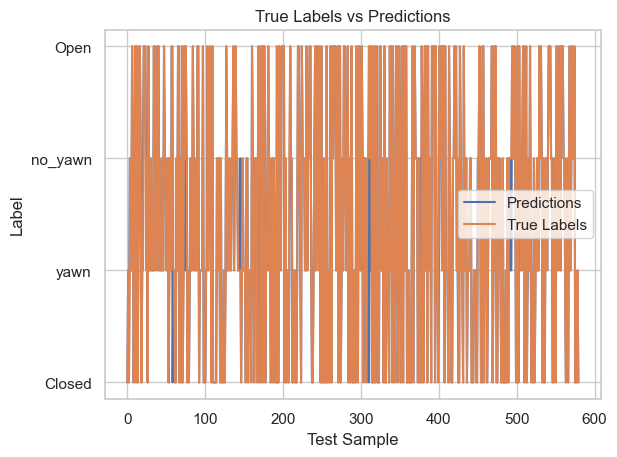

In [21]:
# Plot the accuracy graph
plt.plot(test_predictions_labels, label='Predictions')
plt.plot(y_test_labels, label='True Labels')
plt.xlabel('Test Sample')
plt.ylabel('Label')
plt.title('True Labels vs Predictions')
plt.legend()
plt.show()

In [23]:
# Assuming you have a test image and its corresponding label
test_image_path = r"/Users/yuktasharma/Downloads/train/no_yawn/8.jpg"
true_label = 'no_yawn'  # The true label of the test image

In [24]:
# Load the test image
test_image = cv2.imread(test_image_path)

In [25]:
# Preprocess the test image
preprocessed_test_image = preprocess_image(test_image)

(-0.5, 63.5, 63.5, -0.5)

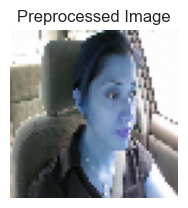

In [26]:
# Display the preprocessed image
plt.subplot(2, 2, 1)
plt.imshow(preprocessed_test_image, cmap='gray')
plt.title('Preprocessed Image')
plt.axis('off')

In [27]:
# Extract features from the preprocessed test image using the CNN model
test_features = feature_extractor.predict(np.expand_dims(preprocessed_test_image, axis=0))

1/1 [==============================] - 0s 17ms/step


(-0.5, 0.5, 127.5, -0.5)

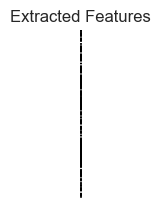

In [28]:
# Display the extracted features
plt.subplot(2, 2, 2)
plt.imshow(test_features.reshape(-1, 1), cmap='gray')
plt.title('Extracted Features')
plt.axis('off')

In [29]:
# Predict the label using the SVM classifier
predicted_label_id = svm_classifier.predict(test_features)[0]
predicted_label = id_to_label[predicted_label_id]

(-0.5, 639.5, 479.5, -0.5)

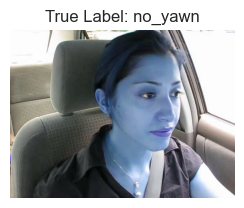

In [30]:
# Display the true label
plt.subplot(2, 2, 3)
plt.imshow(test_image, cmap='gray')
plt.title('True Label: {}'.format(true_label))
plt.axis('off')

True Label was:  no_yawn


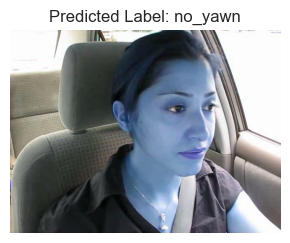

In [31]:
print("True Label was: ",true_label)
# Display the predicted label
plt.subplot(2, 2, 4)
plt.imshow(test_image, cmap='gray')
plt.title('Predicted Label: {}'.format(predicted_label))
plt.axis('off')
# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

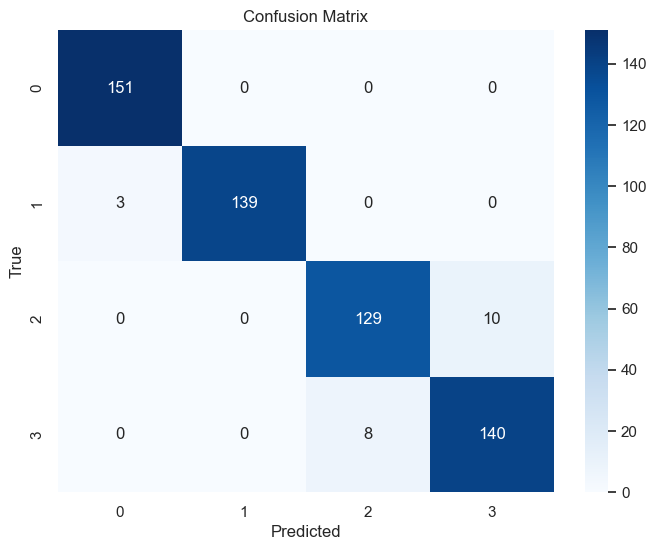

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are your predicted and true labels
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels, test_predictions_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()